# Implicit Solution

## Notes:
* Obvious Note, but one that needs to be made: Implicit Schemes use future information.
    * By using these methods, both the miniscule time step issue and the boundary drag issue disappear
    * We're going to solve the same equations as in Notebook 1 but descritize them differently.
* Solving $\frac{\partial T}{\partial t}=\alpha \frac{\partial^{2}T}{\partial t^{2}}$ with the following constraint: $\sigma = \alpha\frac{\Delta t}{(\Delta x)^{2}} \leq \frac{1}{2}$

* Descritizing the time derivative: $$\frac{\partial T}{\partial t} : T^{n+1}_{i} = T^{n}_{i} + \frac{\partial T}{\partial t}\Delta t + \frac{\partial^{2} T}{\partial t^{2}}\frac{\Delta t^{2}}{2} + \frac{\partial^{3} T}{\partial t^{3}}\frac{\Delta t^{3}}{6} \\
\implies \frac{T^{n+1}_{i} - T^{n}_{i}}{\Delta t} = \frac{\partial T}{\partial t} + \frac{\partial^{2} T}{\partial t^{2}}\frac{\Delta t}{2} + \frac{\partial^{3} T}{\partial t^{3}}\frac{\Delta t^{2}}{6}$$
    * Using big-O notation for the error we get : $$\frac{T^{n+1}_{i} - T^{n}_{i}}{\Delta t} = \frac{\partial T}{\partial t} + O(\Delta t)$$
    
* Descritizing the space derivative (THIS TIME AT n+1!!) we will use central difference, which will give us two equations to then later sum:
$$\frac{\partial^{2} T}{\partial x^{2}} :\begin{align}
&T^{n+1}_{i+1} = T^{n+1}_{i} + \frac{\partial T}{\partial x}\Delta x + \frac{\partial^{2} T}{\partial x^{2}}\frac{\Delta x^{2}}{2} + \frac{\partial^{3} T}{\partial x^{3}}\frac{\Delta x^{3}}{6} + \frac{\partial^{4} T}{\partial x^{4}}\frac{\Delta x^{4}}{24}\\
&T^{n+1}_{i-1} = T^{n+1}_{i} - \frac{\partial T}{\partial x}\Delta x + \frac{\partial^{2} T}{\partial x^{2}}\frac{\Delta x^{2}}{2} - \frac{\partial^{3} T}{\partial x^{3}}\frac{\Delta x^{3}}{6} + \frac{\partial^{4} T}{\partial x^{4}}\frac{\Delta x^{4}}{24}\\
\implies &T^{n+1}_{i+1} + T^{n+1}_{i-1} = 2T^{n+1}_{i} + \frac{\partial^{2} T}{\partial x^{2}}\Delta x^{2} + \frac{\partial^{4} T}{\partial x^{4}}\frac{\Delta x^{4}}{12} \rightarrow \frac{T^{n+1}_{i+1} + T^{n+1}_{i-1} - 2T^{n+1}_{i}}{\Delta x^{2}} = \frac{\partial^{2} T}{\partial x^{2}} + \frac{\partial^{4} T}{\partial x^{4}}\frac{\Delta x^{2}}{12}\end{align}$$
    * Using big-O notation for the error we get : $$\frac{T^{n+1}_{i+1} + T^{n+1}_{i-1} - 2T^{n+1}_{i}}{\Delta x^{2}} = \frac{\partial^{2} T}{\partial x^{2}} + O(\Delta x^{2})$$
    
* this allows the equation to formulate to: $$\frac{T^{n+1}_{i} - T^{n}_{i}}{\Delta t} - O(\Delta t) = \alpha\frac{T^{n+1}_{i+1} + T^{n+1}_{i-1} - 2T^{n+1}_{i}}{\Delta x^{2}} - \alpha O(\Delta x^{2})\\
\implies T^{n+1}_{i} = T^{n}_{i} + \alpha \Delta t \frac{T^{n+1}_{i+1} + T^{n+1}_{i-1} - 2T^{n+1}_{i}}{\Delta x^{2}} + \Delta t [O(\Delta t) - \alpha O(\Delta x^{2})]$$
    * you can ignore the error term and end up with: $$T^{n+1}_{i} = T^{n}_{i} + \alpha \Delta t \frac{T^{n+1}_{i+1} + T^{n+1}_{i-1} - 2T^{n+1}_{i}}{\Delta x^{2}}$$
    
* we can rearrange this to: $$-T^{n}_{i}=\alpha \Delta t \frac{T^{n+1}_{i+1} + T^{n+1}_{i-1} - 2T^{n+1}_{i}}{\Delta x^{2}} - T^{n+1}_{i}$$

* from the stencil in the notebook, we know that $T^{n+1}_{i}$ keeps appearing, which leads to a system of equations we can then solve.

* followed boundary condition on paper, but may need to experiment some more to fully understand it.

* Note: Implicit methods are stable in timesteps. you may also wish to experiment with sparse matrix storage.

## Code: 
all the code will follow this cell. This is to ease runtime and to make sure the scope of all variables remains the same. different iterations of the same code with different values or methods of computing the same solution will be in subsquent cells, while code-notes will be commented like usual.

/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


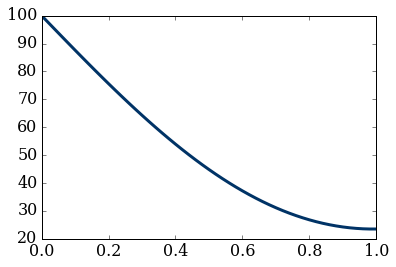

In [1]:
# Basic Imports
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from scipy.linalg import solve

# Setting up initial stuff
L = 1.
nt = 100
nx = 51.
alpha = 1.22e-3
q = 0
dx = L/(nx-1)
qdx = q*dx
Ti = numpy.zeros(nx)
Ti[0] = 100
sigma = 0.5
dt = sigma * dx*dx/alpha 
nt = 1000


# generating a matrix for the solver to solve.
def generateMatrix(N, sigma):
    # Setup the diagonal
    d = numpy.diag(numpy.ones(N-2)*(2+1./sigma))
    # Consider Neumann BC
    d[-1,-1] = 1+1./sigma
    # Setup upper diagonal
    ud = numpy.diag(numpy.ones(N-3)*-1, 1)
    # Setup lower diagonal
    ld = numpy.diag(numpy.ones(N-3)*-1, -1)
    A = d + ud + ld
    return A

# generating the other side of the equation, so all we have left is the solution vector
def generateRHS(T, sigma, qdx):
    b = numpy.zeros_like(T)
    b = T[1:-1]*1./sigma # solve equation.
    # Consider Dirichlet BC
    b[0] += T[0]
    # Consider Neumann BC
    b[-2] += qdx
    return b

# solve out the solution vector implicitly via the solver
def implicit_ftcs(T, A, nt, sigma, qdx):
    for t in range(nt):
        Tn = T.copy()
        b = generateRHS(Tn, sigma, qdx)
        # Use numpy.linalg.solve
        T_interior = solve(A,b)
        T[1:-1] = T_interior
        # Enforce Neumann BC (Dirichlet is enforced automatically)
        T[-1] = T[-2] + qdx
    return T

A = generateMatrix(nx, sigma)
T = implicit_ftcs(Ti.copy(), A, nt, sigma, qdx)
pyplot.plot(numpy.linspace(0,1,nx), T, color='#003366', ls='-', lw=3);

/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


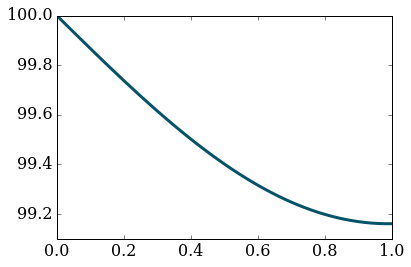

In [2]:
# Basic Imports
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from scipy.linalg import solve

# Setting up initial stuff
L = 1.
nt = 100
nx = 51.
alpha = 1.22e-3
q = 0
dx = L/(nx-1)
qdx = q*dx
Ti = numpy.zeros(nx)
Ti[0] = 100
sigma = 5.0
dt = sigma * dx*dx/alpha 
nt = 1000


# generating a matrix for the solver to solve.
def generateMatrix(N, sigma):
    # Setup the diagonal
    d = numpy.diag(numpy.ones(N-2)*(2+1./sigma))
    # Consider Neumann BC
    d[-1,-1] = 1+1./sigma
    # Setup upper diagonal
    ud = numpy.diag(numpy.ones(N-3)*-1, 1)
    # Setup lower diagonal
    ld = numpy.diag(numpy.ones(N-3)*-1, -1)
    A = d + ud + ld
    return A

# generating the other side of the equation, so all we have left is the solution vector
def generateRHS(T, sigma, qdx):
    b = numpy.zeros_like(T)
    b = T[1:-1]*1./sigma # solve equation.
    # Consider Dirichlet BC
    b[0] += T[0]
    # Consider Neumann BC
    b[-2] += qdx
    return b

# solve out the solution vector implicitly via the solver
def implicit_ftcs(T, A, nt, sigma, qdx):
    for t in range(nt):
        Tn = T.copy()
        b = generateRHS(Tn, sigma, qdx)
        # Use numpy.linalg.solve
        T_interior = solve(A,b)
        T[1:-1] = T_interior
        # Enforce Neumann BC (Dirichlet is enforced automatically)
        T[-1] = T[-2] + qdx
    return T

A = generateMatrix(nx, sigma)
T = implicit_ftcs(Ti.copy(), A, nt, sigma, qdx)
pyplot.plot(numpy.linspace(0,1,nx), T, color='#045366', ls='-', lw=3);